In [33]:
import pandas as pd
import pickle
import numpy as np

from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix,
                            recall_score, f1_score, roc_curve, auc)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv('maintenance_prediction.csv')
df

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,11/2/2015,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,11/2/2015,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,11/2/2015,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,11/2/2015,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [35]:
#檢查有無缺失或重複值
df.info()

df.isna().any()

df.loc[df.duplicated()]

dup_rows = df.duplicated().sum()
print(f'\n重複的行數: {dup_rows}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB

重複的行數: 1


In [36]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.492706,9.940897,1.741120,14.222669,260172.657726,0.292528,0.292528,13.013848
std,0.029167,7.045933e+07,2179.677781,185.748131,22.908507,15.943028,99151.078547,7.436924,7.436924,275.661220
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000


In [37]:
#回答Q1

device_unique_count = df['device'].nunique()
print(f'有{device_unique_count}種裝置')

有1169種裝置


In [38]:
#回答Q2

normal_device = df[df['failure'] == 0].value_counts().count()
abnormal_device = df[df['failure'] == 1].value_counts().count()
print(f'正常運作: {normal_device}\n發生故障: {abnormal_device}')

正常運作: 124387
發生故障: 106


In [39]:
#製作工作日+月份+星期幾欄位
df['date'] = pd.to_datetime(df['date'], format='mixed')

df['activedays']=df.date-df.date[0]

df['month'] = df['date'].apply(lambda i : i.month)
month_label = {1.0 : 'Jan', 2.0 : 'Feb', 3.0 : 'Mar', 4.0 : 'Apr', 5.0 : 'May', 6.0 : 'Jun', 
               7.0 : 'Jul', 8.0 : 'Aug', 9.0 : 'Sep', 10.0 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df['day'] = df['date'].dt.day_of_week + 1

df

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,day
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,0 days,1,4
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,0 days,1,4
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,0 days,1,4
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,0 days,1,4
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,0 days,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,305 days,11,1
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,305 days,11,1
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,305 days,11,1
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,305 days,11,1


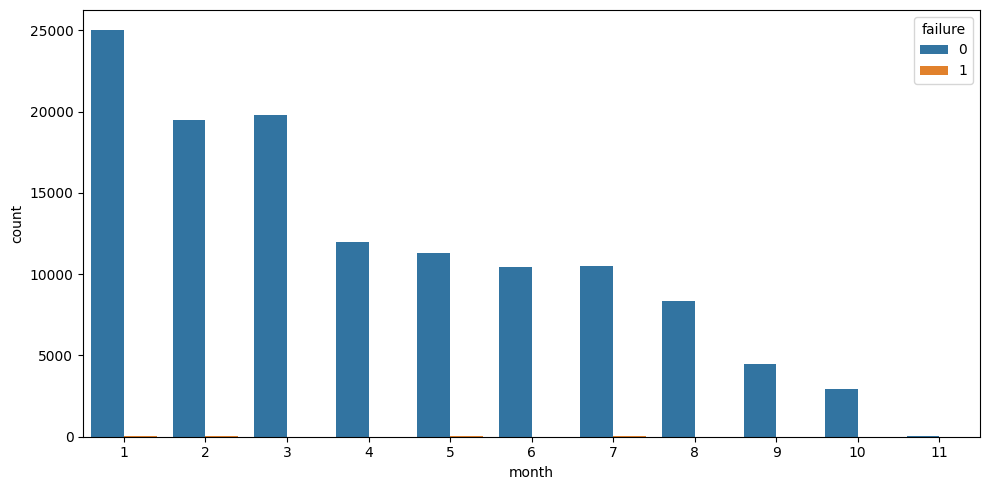

In [40]:
#顯示每個月裝置的狀態
plt.figure(figsize=(10, 5))
sns.countplot(x='month', hue='failure', data=df)
plt.xlabel('month')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [41]:
#製作每個月裝置failure=0的df
df2 = df[df['failure'] == 0]

df2.describe()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,day
count,124388,124388.0,1.243880e+05,124388.000000,124388.000000,124388.000000,124388.000000,124388.000000,124388.000000,124388.000000,124388.000000,124388,124388.000000,124388.000000
mean,2015-04-16 05:18:45.832073984,0.0,1.223840e+08,156.126676,9.946040,1.696048,14.221613,260174.250587,0.266682,0.266682,13.005266,105 days 05:18:45.832073836,4.028274,4.013201
min,2015-01-01 00:00:00,0.0,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0 days 00:00:00,1.000000,1.000000
25%,2015-02-09 00:00:00,0.0,6.126677e+07,0.000000,0.000000,0.000000,8.000000,221451.000000,0.000000,0.000000,0.000000,39 days 00:00:00,2.000000,2.000000
50%,2015-03-27 00:00:00,0.0,1.227861e+08,0.000000,0.000000,0.000000,10.000000,249794.000000,0.000000,0.000000,0.000000,85 days 00:00:00,3.000000,4.000000
75%,2015-06-17 00:00:00,0.0,1.833093e+08,0.000000,0.000000,0.000000,12.000000,310266.250000,0.000000,0.000000,0.000000,167 days 00:00:00,6.000000,6.000000
max,2015-11-02 00:00:00,0.0,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,70000.000000,305 days 00:00:00,11.000000,7.000000
std,NaN,0.0,7.046036e+07,2145.542364,185.824914,22.164316,15.943381,99147.843106,6.558071,6.558071,275.742454,78 days 09:58:59.463933922,2.572260,2.001258


In [42]:
#製作每個月裝置failure=1的df
df3 = df[df['failure'] == 1]

df3.describe()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,day
count,106,106.0,1.060000e+02,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106,106.000000,106.000000
mean,2015-04-17 21:44:09.056603648,1.0,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906,106 days 21:44:09.056603774,4.056604,3.132075
min,2015-01-05 00:00:00,1.0,4.527376e+06,0.000000,0.000000,0.000000,3.000000,24.000000,0.000000,0.000000,0.000000,4 days 00:00:00,1.000000,1.000000
25%,2015-02-04 00:00:00,1.0,7.046235e+07,0.000000,0.000000,0.000000,8.000000,230028.750000,0.000000,0.000000,0.000000,34 days 00:00:00,2.000000,1.250000
50%,2015-04-24 00:00:00,1.0,1.391173e+08,0.000000,0.000000,1.500000,10.000000,267648.500000,0.000000,0.000000,0.000000,113 days 00:00:00,4.000000,3.000000
75%,2015-06-13 06:00:00,1.0,1.837066e+08,1182.000000,0.000000,18.750000,14.000000,309156.000000,16.000000,16.000000,1.000000,163 days 06:00:00,6.000000,4.000000
max,2015-10-26 00:00:00,1.0,2.432612e+08,64784.000000,318.000000,1666.000000,91.000000,574599.000000,832.000000,832.000000,1165.000000,298 days 00:00:00,10.000000,7.000000
std,NaN,0.0,6.940167e+07,12803.747239,31.557213,193.492528,15.547270,103349.308593,117.033610,117.033610,153.449984,74 days 00:25:40.206411879,2.472054,1.773216


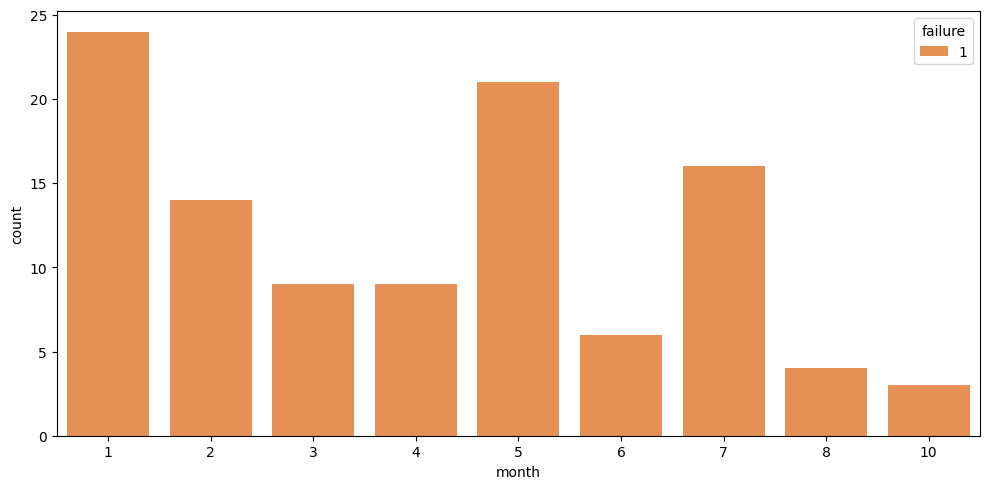

In [43]:
#顯示每個月故障的裝置
plt.figure(figsize=(10, 5))
sns.countplot(x='month', hue='failure', data=df3, palette='Oranges')
plt.xlabel('month')
plt.ylabel('count')
plt.tight_layout()
plt.show()


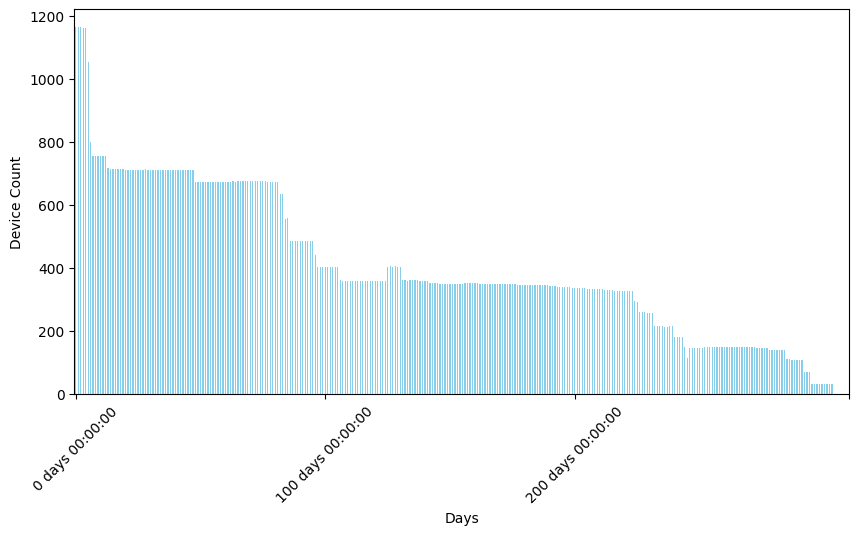

In [44]:
#每日裝置活動量
device_counts = df.groupby(['activedays'])['device'].count()

plt.figure(figsize=(10, 5))
device_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Days')
plt.xticks([0, 100, 200, 310], rotation=45)
plt.ylabel('Device Count')
plt.show()

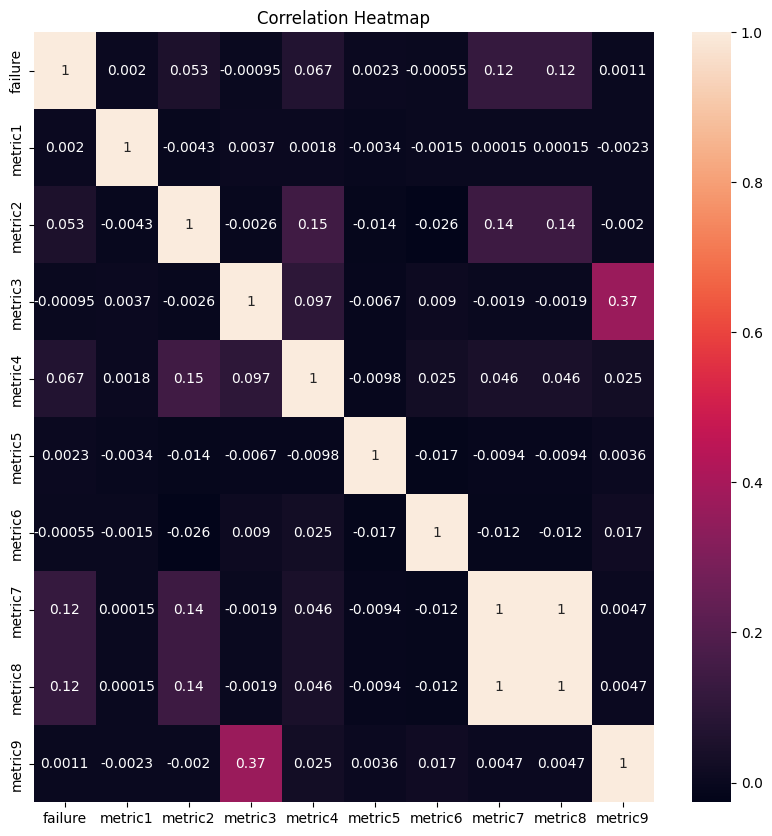

In [45]:
#繪製9個指標+failure相關性熱度
df_corr = df.drop(columns=['date', 'device', 'activedays', 'month', 'day'])
corr = df_corr.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

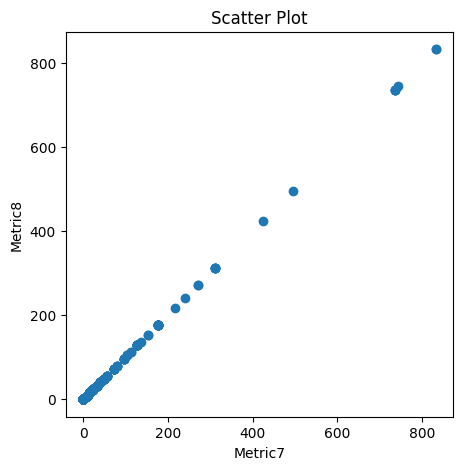

In [46]:
#繪製指標7跟8的散點圖
plt.figure(figsize=(5, 5))
plt.scatter(df['metric7'], df['metric8'])
plt.title('Scatter Plot')
plt.xlabel('Metric7')
plt.ylabel('Metric8')
plt.show()

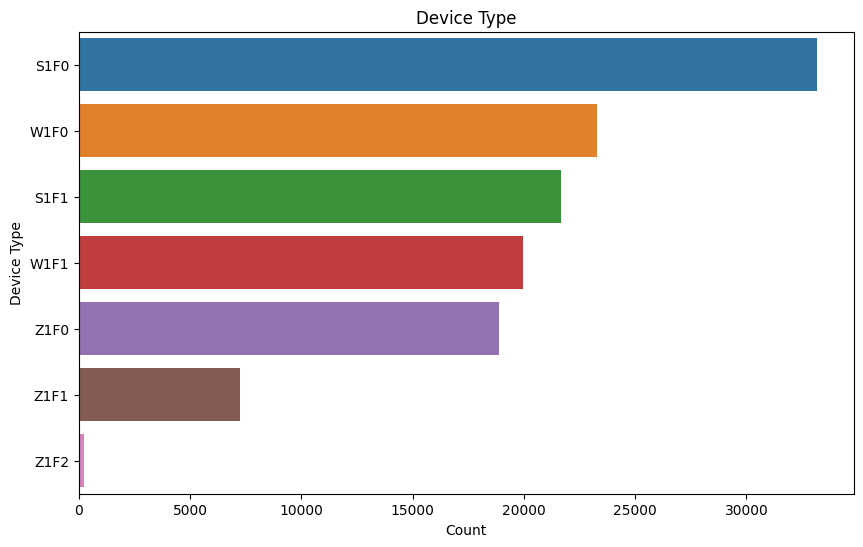

In [47]:
#確認各個裝置型號數量 只取前四個字元
df["device_type"] = df["device"].apply(lambda x : x[:4])
device_type_counts = df["device_type"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=device_type_counts.values, y=device_type_counts.index, hue=device_type_counts.index, palette="tab10", legend=False)
plt.xlabel("Count")
plt.ylabel("Device Type")
plt.title("Device Type")
plt.show()

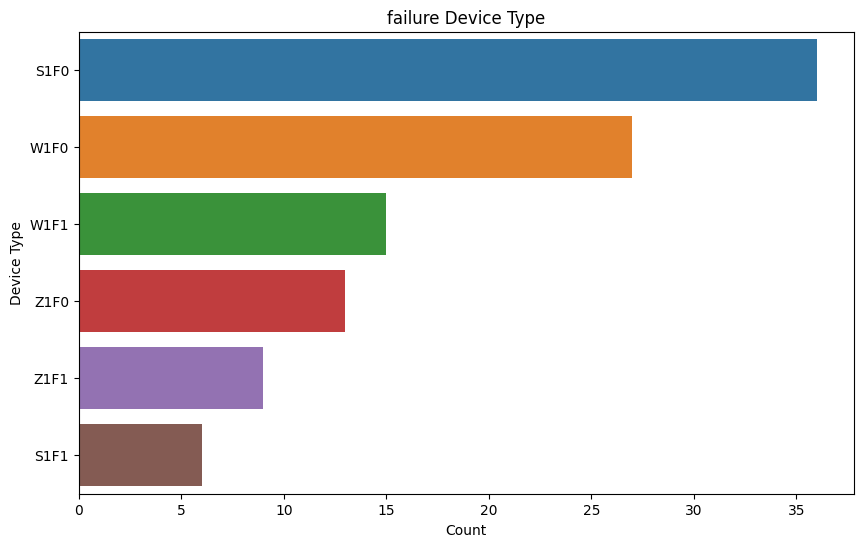

In [48]:
#最多故障的型號
df_failure = df[df["failure"] == 1].copy()
df_failure["device_type"] = df_failure["device"].apply(lambda x : x[:4])
device_failure_counts = df_failure["device_type"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=device_failure_counts.values, y=device_failure_counts.index, hue=device_failure_counts.index, palette="tab10", legend=False)
plt.xlabel("Count")
plt.ylabel("Device Type")
plt.title("failure Device Type")
plt.show()

In [49]:
#製作訓練模型的特徵與標籤
X = df.drop(['date', 'device', 'failure', 'activedays', 'month', 'day', 'device_type'], axis=1)
y = df['failure']

In [50]:
#平衡資料集

from imblearn.over_sampling import SMOTE
from collections import Counter

smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X, y)
print(Counter(y_smo))

Counter({0: 124388, 1: 124388})


In [51]:
'''
以下開始尋找8個模型最佳解 並儲存模型
'''

'\n以下開始尋找8個模型最佳解 並儲存模型\n'

In [52]:
#模型1: Decision Tree

from sklearn import tree

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
depth = 21
depthvalues = [i for i in range(1, depth)]
leaf = 10
leafvalues = [i for i in range(1, leaf)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_depth = 0
relative_best_leaf = 0
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    for i in depthvalues:
        for j in leafvalues:
            clf = tree.DecisionTreeClassifier(random_state=42, max_depth=i, min_samples_leaf=j)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            test_acc = accuracy_score(y_test, y_pred_test)

            fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
            roc_auc = auc(fpr, tpr)

            if roc_auc > relative_best_roc_auc:
                relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
                relative_best_test_score = test_acc
                relative_best_ratio = k
                relative_best_depth = i
                relative_best_leaf = j
                relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
                relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                relative_best_roc_auc = roc_auc
                best_fpr, best_tpr = fpr, tpr 
                best_cm = confusion_matrix(y_test, y_pred_test) 
                best_clf = clf

print("best ratio of testing data:", relative_best_ratio, 
        "\nbest depth:", relative_best_depth, 
        "\nbest min_sample_leaf:", relative_best_leaf,
        "\nTraining score:", relative_best_train_score, 
        "\nTesting score:", relative_best_test_score,      
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nConfusion Matrix:\n", best_cm)     


with open('best_decision_tree_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 20 
best depth: 16 
best min_sample_leaf: 7 
Training score: 0.9953672997688674 
Testing score: 0.9938499879411529 
F1 score: 0.9938498241720287 
Recall: 0.9938499879411529 
Precision: 0.9938702172658139 
ROC AUC: 0.9986001690279006 

Confusion Matrix:
 [[24519   233]
 [   73 24931]]


In [53]:
#模型2: KNN

from sklearn import neighbors

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
neighbor = 10
neighborvalues = [i for i in range(1, neighbor)]
p = 3
pvalues = [i for i in range(1, p)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_neighbor = 0
relative_best_p = 0
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    for i in neighborvalues:
        for j in pvalues:
            clf = neighbors.KNeighborsClassifier(n_neighbors=i, p=j)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            test_acc = accuracy_score(y_test, y_pred_test)

            fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
            roc_auc = auc(fpr, tpr)

            if roc_auc > relative_best_roc_auc:
                relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
                relative_best_test_score = test_acc
                relative_best_ratio = k
                relative_best_neighbor = i
                relative_best_p = j
                relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
                relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                relative_best_roc_auc = roc_auc
                best_fpr, best_tpr = fpr, tpr
                best_cm = confusion_matrix(y_test, y_pred_test)
                best_clf = clf

print("best ratio of testing data:", relative_best_ratio, 
        "\nbest neighbors:", relative_best_neighbor, 
        "\nbest p:", relative_best_p,
        "\nTraining score:", relative_best_train_score, 
        "\nTesting score:", relative_best_test_score, 
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm) 

with open('best_knn_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 10 
best neighbors: 6 
best p: 1 
Training score: 0.9134471947047316 
Testing score: 0.8746683817027092 
F1 score: 0.8745993066322394 
Recall: 0.8746683817027092 
Precision: 0.8754568204913329 
ROC AUC: 0.9420963782275333 

confusion matrix:
 [[10582  1845]
 [ 1273 11178]]


In [54]:
#模型3: RandomForest

from sklearn.ensemble import RandomForestClassifier

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
n_estimator = 250
n_estimatorvalues = [i for i in range(100, n_estimator, 50)]
depth = 8
depthvalues = [i for i in range(1, depth)]
leaf = 5
leafvalues = [i for i in range(1, leaf)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_estimators = 0
relative_best_depth = 0
relative_best_leaf = 0
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=71)
    for l in n_estimatorvalues:
        for i in depthvalues:
            for j in leafvalues:
                clf = RandomForestClassifier(random_state=71, n_estimators=l, max_depth=i, min_samples_leaf=j)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                test_acc = accuracy_score(y_test, y_pred_test)

                fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
                roc_auc = auc(fpr, tpr)

                if roc_auc > relative_best_roc_auc:
                    relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
                    relative_best_test_score = test_acc
                    relative_best_ratio = k
                    relative_best_estimators = l
                    relative_best_depth = i
                    relative_best_leaf = j
                    relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                    relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
                    relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                    relative_best_roc_auc = roc_auc
                    best_fpr, best_tpr = fpr, tpr
                    best_cm = confusion_matrix(y_test, y_pred_test)
                    best_clf = clf

print("best ratio of testing data:", relative_best_ratio, 
        "\nbest no. of estimators:", relative_best_estimators, 
        "\nbest depth:", relative_best_depth, 
        "\nbest min_sample_leaf:", relative_best_leaf,
        "\nTraining score:", relative_best_train_score, 
        "\nTesting score:", relative_best_test_score,
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm)

with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 10 
best no. of estimators: 100 
best depth: 7 
best min_sample_leaf: 1 
Training score: 0.9515091693539022 
Testing score: 0.9526489267626015 
F1 score: 0.9526493478577127 
Recall: 0.9526489267626015 
Precision: 0.952672537173894 
ROC AUC: 0.9908019162181191 

confusion matrix:
 [[11818   546]
 [  632 11882]]


In [55]:
#模型4: XGBoost

from xgboost.sklearn import XGBClassifier

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
n_estimator = 250
n_estimatorvalues = [i for i in range(100, n_estimator, 50)]
depth = 8
depthvalues = [i for i in range(1, depth)]
rate = 3
ratevalues = [i for i in range(1, rate)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_estimators = 0
relative_best_depth = 0
relative_best_rate = 0
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    for l in n_estimatorvalues:
        for i in depthvalues:
            for j in ratevalues:
                clf = XGBClassifier(random_state=42, n_estimators=l, max_depth=i, learning_rate=j)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                test_acc = accuracy_score(y_test, y_pred_test)

                fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
                roc_auc = auc(fpr, tpr)

                if roc_auc > relative_best_roc_auc:
                    relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
                    relative_best_test_score = test_acc
                    relative_best_ratio = k
                    relative_best_estimators = l
                    relative_best_depth = i
                    relative_best_rate = j
                    relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                    relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
                    relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                    relative_best_roc_auc = roc_auc
                    best_fpr, best_tpr = fpr, tpr
                    best_cm = confusion_matrix(y_test, y_pred_test)
                    best_clf = clf

print("best ratio of testing data:", relative_best_ratio,
        "\nbest no. of estimators:", relative_best_estimators,
        "\nbest depth:", relative_best_depth,
        "\nbest learning_rate:", relative_best_rate,
        "\nTraining score:", relative_best_train_score,
        "\nTesting score:", relative_best_test_score,
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm)

with open('best_xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 10 
best no. of estimators: 200 
best depth: 5 
best learning_rate: 1 
Training score: 0.9996605597191578 
Testing score: 0.998351957552858 
F1 score: 0.998351953460126 
Recall: 0.998351957552858 
Precision: 0.9983546625776393 
ROC AUC: 0.9999812639652209 

confusion matrix:
 [[12392    35]
 [    6 12445]]


In [56]:
#模型5: LogisticRegression

from sklearn.linear_model import LogisticRegression

ratio = 100
ratio_values = [i for i in range(10, ratio, 10)]
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
class_weight_values = [None, 'balanced']
solver_values = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_train_score = 0
best_test_score = 0
best_ratio = 0
best_C = 0
best_class_weight = ''
best_solver = ''
best_f1_score = 0
best_recall = 0
best_precision = 0
best_roc_auc = 0

for k in ratio_values:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    for i in C_values:
        for j in class_weight_values:
            for r in solver_values:
                clf = LogisticRegression(C=i, class_weight=j, solver=r, max_iter=1000)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                test_acc = accuracy_score(y_test, y_pred_test)

                fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
                roc_auc = auc(fpr, tpr)

                if roc_auc > best_roc_auc:
                    best_train_score = accuracy_score(y_train, clf.predict(X_train))
                    best_test_score = test_acc
                    best_ratio = k
                    best_C = i
                    best_class_weight = j
                    best_solver = r
                    best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                    best_recall = recall_score(y_test, y_pred_test, average='weighted')
                    best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                    best_roc_auc = roc_auc
                    best_fpr, best_tpr = fpr, tpr
                    best_cm = confusion_matrix(y_test, y_pred_test)
                    best_clf = clf

print("best ratio of testing data:", best_ratio,
        "\nbest C:", best_C,
        "\nbest class weight:", best_class_weight,
        "\nbest solver:", best_solver,
        "\nTraining score:", best_train_score,
        "\nTesting score:", best_test_score,
        "\nF1 score:", best_f1_score,
        "\nRecall:", best_recall,
        "\nPrecision:", best_precision,
        "\nROC AUC:", best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm)

with open('best_logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

d:\NTU_hw_test\test1\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
d:\NTU_hw_test\test1\lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
d:\NTU_hw_test\test1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\NTU_hw_test\test1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\NTU_hw_test\test1\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
d:\NTU_hw_test\test1\lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWa

best ratio of testing data: 50 
best C: 0.001 
best class weight: None 
best solver: newton-cg 
Training score: 0.8295012380615493 
Testing score: 0.8299996784255717 
F1 score: 0.8265715691284997 
Recall: 0.8299996784255717 
Precision: 0.8591322982208492 
ROC AUC: 0.9284177527878333 

confusion matrix:
 [[60272  1731]
 [19415 42970]]


d:\NTU_hw_test\test1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [57]:
#模型6: Gaussian Naive bayes

from sklearn.naive_bayes import GaussianNB

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    if roc_auc > relative_best_roc_auc:
        relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
        relative_best_test_score = test_acc
        relative_best_ratio = k
        relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
        relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
        relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
        relative_best_roc_auc = roc_auc
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, y_pred_test)
        best_clf = clf

print("best ratio of testing data:", relative_best_ratio,
        "\nTraining score:", relative_best_train_score,
        "\nTesting score:", relative_best_test_score,
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm)


with open('best_gaussian_nb_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 20 
Training score: 0.5812933373530298 
Testing score: 0.5826031031433395 
F1 score: 0.4985322925728504 
Recall: 0.5826031031433395 
Precision: 0.7592581370799897 
ROC AUC: 0.67610315510475 

confusion matrix:
 [[24628   124]
 [20644  4360]]


In [58]:
#模型7: Multinomail Naive bayes

from sklearn.naive_bayes import MultinomialNB

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
fit_prior_values = [True, False]
class_prior_values = [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_alpha = 0
relative_best_fit_prior = True
relative_best_class_prior = None
relative_best_f1_score = 0
relative_best_recall = 0
relative_best_precision = 0
relative_best_roc_auc = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=42)
    for i in alpha_values:
        for j in fit_prior_values:
            for r in class_prior_values:
                clf = MultinomialNB(alpha=i, fit_prior=j, class_prior=r)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                test_acc = accuracy_score(y_test, y_pred_test)

                fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
                roc_auc = auc(fpr, tpr)

                if roc_auc > relative_best_roc_auc:
                    relative_best_train_score = accuracy_score(y_train, clf.predict(X_train))
                    relative_best_test_score = test_acc
                    relative_best_ratio = k
                    relative_best_alpha = i
                    relative_best_fit_prior = j
                    relative_best_class_prior = r
                    relative_best_f1_score = f1_score(y_test, y_pred_test, average='weighted')
                    relative_best_recall = recall_score(y_test, y_pred_test, average='weighted')
                    relative_best_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
                    relative_best_roc_auc = roc_auc
                    best_fpr, best_tpr = fpr, tpr
                    best_cm = confusion_matrix(y_test, y_pred_test)
                    best_clf = clf

print("best ratio of testing data:", relative_best_ratio,
        "\nbest alpha:", relative_best_alpha,
        "\nbest fit_prior:", relative_best_fit_prior,
        "\nbest class_prior:", relative_best_class_prior,
        "\nTraining score:", relative_best_train_score,
        "\nTesting score:", relative_best_test_score,
        "\nF1 score:", relative_best_f1_score,
        "\nRecall:", relative_best_recall,
        "\nPrecision:", relative_best_precision,
        "\nROC AUC:", relative_best_roc_auc,
        "\n\nconfusion matrix:\n", best_cm)

with open('best_multinomial_nb_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

best ratio of testing data: 80 
best alpha: 0.001 
best fit_prior: True 
best class_prior: [0.1, 0.9] 
Training score: 0.6171641041101397 
Testing score: 0.6147642711070691 
F1 score: 0.6107922300667114 
Recall: 0.6147642711070691 
Precision: 0.6197554574696268 
ROC AUC: 0.62259157694686 

confusion matrix:
 [[71188 28241]
 [48429 51163]]


In [59]:
#模型8 SVM

from sklearn import svm
from sklearn.model_selection import GridSearchCV

kernel_values = ["rbf", "poly"]
gamma_values = ["scale"]
param_grid = {'kernel': kernel_values, 'gamma': gamma_values,}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svc = svm.SVC(random_state=42, probability=True)
grid = GridSearchCV(svc, param_grid, refit=True, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_test = best_model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
best_cm = confusion_matrix(y_test, y_pred_test)

print("Best parameters found:", grid.best_params_,
      "\nROC AUC:", roc_auc,
      "\n\nconfusion matrix:\n", best_cm)

with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Best parameters found: {'gamma': 'scale', 'kernel': 'rbf'} 
ROC AUC: 0.5212187791666109 

confusion matrix:
 [[24881     0]
 [   18     0]]


In [60]:
'''
用8個儲存的模型來預測原始資料集 並計算多個指標與視覺化 
'''

'\n用8個儲存的模型來預測原始資料集 並計算多個指標與視覺化 \n'

Model: xgboost
Accuracy: 0.9999839349687535
F1 Score: 0.9999838585331805
Recall: 0.9999839349687535
Precision: 0.9999839352270545
Roc auc: 0.9999998483139488


Model: decision_tree
Accuracy: 0.992096004626729
F1 Score: 0.9952957484474696
Recall: 0.992096004626729
Precision: 0.9989685996139189
Roc auc: 0.9915620841906123


Model: gaussian_nb
Accuracy: 0.9941041335325397
F1 Score: 0.9962232405500994
Recall: 0.9941041335325397
Precision: 0.9984151485423506
Roc auc: 0.6178328340839772


Model: knn
Accuracy: 0.8905891046958087
F1 Score: 0.9412877948179178
Recall: 0.8905891046958087
Precision: 0.9991460470335923
Roc auc: 0.9947813172538029


Model: logistic_regression
Accuracy: 0.9707937731938888
F1 Score: 0.98436032797318
Recall: 0.9707937731938888
Precision: 0.9987482684087746
Roc auc: 0.8359292378504024


Model: multinomial_nb
Accuracy: 0.7154079714685045
F1 Score: 0.8333156620456476
Recall: 0.7154079714685045
Precision: 0.9984878914406137
Roc auc: 0.5910749596060046


Model: random_fores

d:\NTU_hw_test\test1\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: svm
Accuracy: 0.9991485533439363
F1 Score: 0.9987230113334474
Recall: 0.9991485533439363
Precision: 0.9982978316492805
Roc auc: 0.4780431028049178




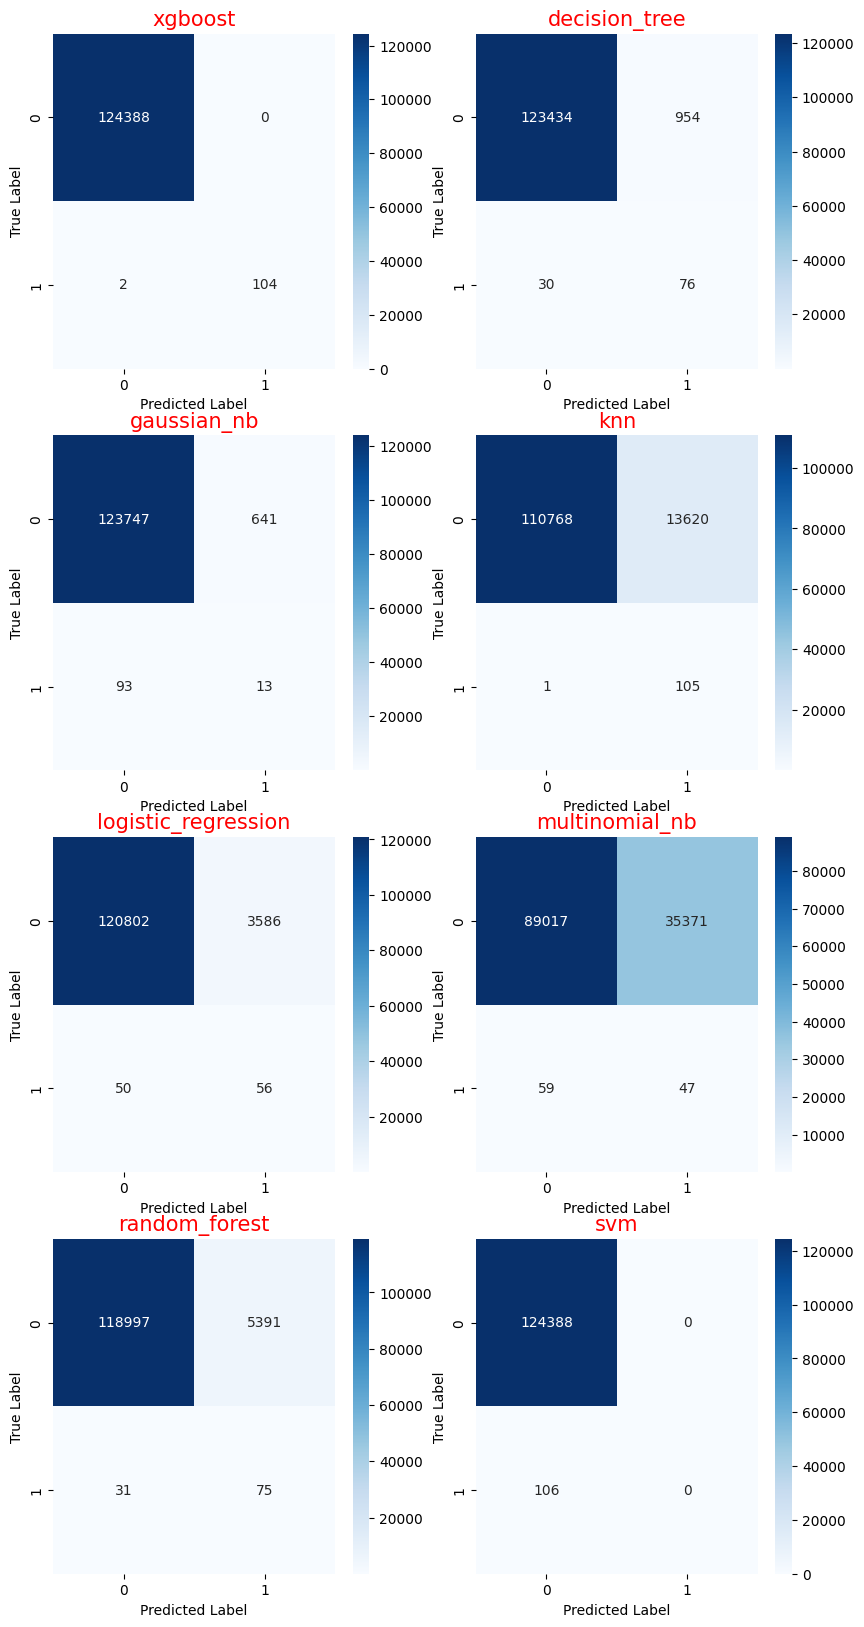

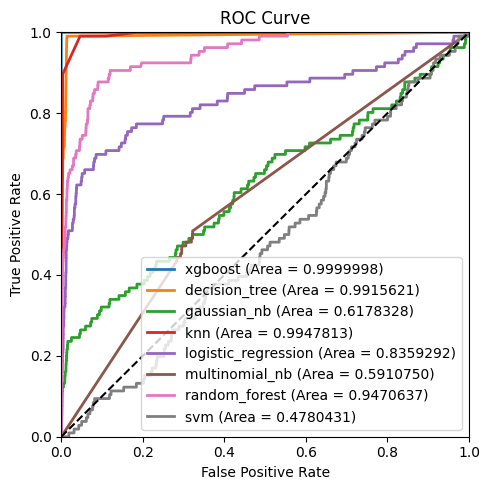

In [65]:
#回答Q3

data = pd.read_csv('maintenance_prediction.csv')
X = data[['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']]
y = data['failure']

model_files = [
    'best_xgboost_model.pkl',
    'best_decision_tree_model.pkl',
    'best_gaussian_nb_model.pkl',
    'best_knn_model.pkl',
    'best_logistic_regression_model.pkl',
    'best_multinomial_nb_model.pkl',
    'best_random_forest_model.pkl',
    'best_svm_model.pkl']

performance_data = []

fig, axes = plt.subplots(4, 2, figsize=(10, 20)) 
axes = axes.flatten()

roc_fig, roc_ax = plt.subplots(figsize=(5, 5))

for i, model_file in enumerate(model_files):
    with open(model_file, 'rb') as file:
        model = pickle.load(file)

    model_name = model_file.replace('best_', '').replace('_model.pkl', '')

    predictions = model.predict(X)
    probas = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, probas)
    roc_auc = auc(fpr, tpr)

    roc_ax.plot(fpr, tpr, lw=2, label=f'{model_name} (Area = {roc_auc:.7f})')
    
    cm = confusion_matrix(y, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(model_name, fontsize=15, color='red')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    
    accuracy = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    precision = precision_score(y, predictions, average='weighted')
    
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Roc auc:", roc_auc)
    print("\n")
    
    performance_data.append({
    'Model': model_name,
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Recall': recall,
    'Precision': precision,
    'ROC AUC': roc_auc})
    
performance_df = pd.DataFrame(performance_data)
performance_df.to_csv('all_model_metrics.csv', index=False)

roc_ax.plot([0, 1], [0, 1], color='black', linestyle='--')
roc_ax.set_xlim([0, 1])
roc_ax.set_ylim([0, 1])
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title('ROC Curve')
roc_ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [66]:
#儲存各模型的準確率等指標

df2 = pd.read_csv('all_model_metrics.csv')

df2

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC
0,xgboost,0.999984,0.999984,0.999984,0.999984,1.000000
1,decision_tree,0.992096,0.995296,0.992096,0.998969,0.991562
2,gaussian_nb,0.994104,0.996223,0.994104,0.998415,0.617833
3,knn,0.890589,0.941288,0.890589,0.999146,0.994781
4,logistic_regression,0.970794,0.984360,0.970794,0.998748,0.835929
5,multinomial_nb,0.715408,0.833316,0.715408,0.998488,0.591075
6,random_forest,0.956448,0.976916,0.956448,0.998900,0.947064
7,svm,0.999149,0.998723,0.999149,0.998298,0.478043


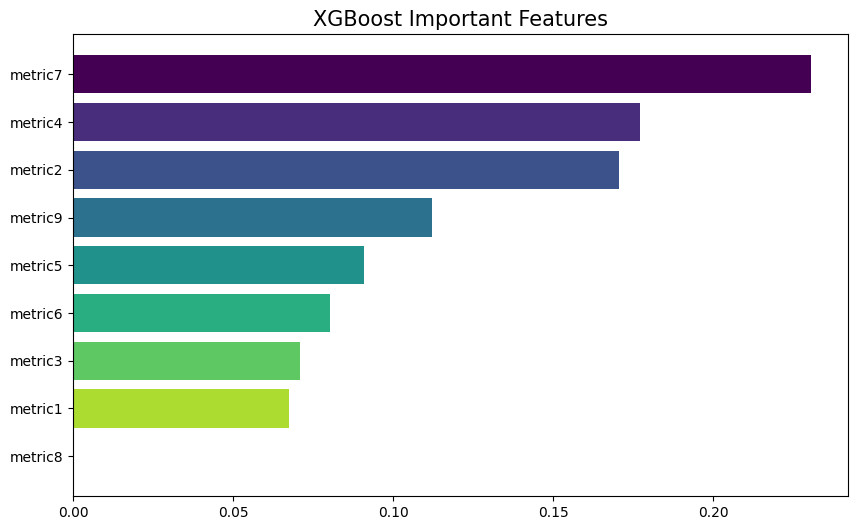

In [67]:
#回答Q4

import xgboost as xgb

X = data[['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']]
y = data['failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

best_xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=1, max_depth=5, random_state=42)
best_xgb_model.fit(X_train, y_train)
importance = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

colors = plt.cm.viridis(np.linspace(0, 1, len(X.columns)))
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.title('XGBoost Important Features', fontsize=15)
plt.gca().invert_yaxis()
plt.show()

In [68]:
#回答Q5

AA = best_xgb_model.predict([[127175526, 4109.434, 3.90566, 54.63208, 15.46226,
                                258303.5, 30.62264, 30.62264, 23.08491]])

BB = best_xgb_model.predict([[4527376, 0, 0, 0, 3, 24, 0, 0, 0]])

print('Device AA 預測為:', AA)

print('Device BB 預測為:', BB)

Device AA 預測為: [0]
Device BB 預測為: [0]
